In [1]:
# Imports
import pandas as pd
import spacy
import re
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from transformers import pipeline, set_seed
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = '/content/drive/MyDrive/LLM_thesis/filtered_df.parquet'
filtered_df = pd.read_parquet(file_path)

Creating a balanced subset for embedding analysis

In [4]:
# Takes a subset of 10 sentences with gendered terms per category
balanced_sample = []

for cat in sorted(filtered_df["stereotype"].unique()):
    group = filtered_df[filtered_df["stereotype"] == cat]

    # Filters for gendered terms with non-capturing group to avoid warning
    gendered = group[group["sentence"].str.lower().str.contains(
        r"\b(?:he|she|man|woman|boy|girl|his|her|men|women)\b", regex=True, na=False)]

    if len(gendered) >= 10:
        sample = gendered.sample(n=10, random_state=42)
    else:
        sample = gendered  # take all available
        print(f"⚠️ Not enough gendered examples in category {cat}: only {len(gendered)} found")

    balanced_sample.append(sample)

final_subset_df = pd.concat(balanced_sample).reset_index(drop=True)
print(f"✅ Final balanced subset: {len(final_subset_df)} sentences")
final_subset_df.to_parquet("subset_df.parquet", index=False)

⚠️ Not enough gendered examples in category 4: only 9 found
⚠️ Not enough gendered examples in category 5: only 8 found
⚠️ Not enough gendered examples in category 10: only 5 found
⚠️ Not enough gendered examples in category 11: only 8 found
⚠️ Not enough gendered examples in category 13: only 5 found
⚠️ Not enough gendered examples in category 15: only 5 found
✅ Final balanced subset: 140 sentences


Eventhough should be 160, it is 140. Keep it like this for integrity purposes. Ask jelke if he considers it is better to manually add sentences for the underepresented categories.

### Improving extraction logic (first tying dependency-based adjectives/nouns, and if there are none then we have the proximity fallback)

In [5]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_gender_and_closest_token(text):
    doc = nlp(text)
    gender_terms = {"he", "she", "his", "her", "man", "woman", "boy", "girl", "women", "men"}
    gender_idxs = [i for i, token in enumerate(doc) if token.text.lower() in gender_terms]

    if not gender_idxs:
        return pd.Series([None, None])

    gender_token = doc[gender_idxs[0]]
    gender_term = gender_token.text

    # First try: dependency-based related adjectives/nouns
    related = [child.text for child in gender_token.children
               if child.pos_ in {"ADJ", "NOUN"} and not child.is_stop]

    if related:
        return pd.Series([gender_term, related[0]])

    # Fallback: distance-based search
    uninformative_words = {"lot", "lots", "many", "thing", "stuff", "one", "someone"}
    candidates = [(i, token.text) for i, token in enumerate(doc)
                  if token.pos_ in {"NOUN", "ADJ"}
                  and token.text.lower() not in gender_terms
                  and not token.is_stop
                  and token.text.lower() not in uninformative_words]

    if not candidates:
        # If no noun or adjective, fallback to using a VERB
        verb_candidates = [(i, token.text) for i, token in enumerate(doc)
                           if token.pos_ == "VERB"
                           and token.text.lower() not in gender_terms
                           and not token.is_stop]
        if verb_candidates:
            closest_verb = min(verb_candidates, key=lambda x: abs(x[0] - gender_token.i))
            return pd.Series([gender_term, closest_verb[1]])
        else:
            return pd.Series([gender_term, None])

    closest = min(candidates, key=lambda x: abs(x[0] - gender_token.i))
    return pd.Series([gender_term, closest[1]])

In [6]:
final_subset_df[["pronoun", "relevant_token"]] = final_subset_df["sentence"].apply(extract_gender_and_closest_token)

### Switching baseline model to BERT
- I am switching the baseline model from GPT-2 to BERT because BERT supports masked completions, making it easier to design and evaluate prompt-based sentence completions in a structured way. This allows for a more direct comparison with LLaMA-2, which will also be used for completion-based prompts. To quantify bias, masking the pronoun and prompting the model to complete the sentence provides a clearer and more interpretable signal of gender associations in the model's outputs.

Sources:
- https://huggingface.co/docs/transformers/model_doc/bert
- https://bert-vs-gpt2.dbvis.de/

In [22]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

### Computing cosine similarity at the token level for gendered term & adj/noun for BERT

In [8]:
# same function as gpt2
def get_bert_token_embedding(text, target_token):
    if not target_token:
        return None
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())

    match_indices = [i for i, tok in enumerate(tokens) if target_token.lower() in tok.lower()]
    if not match_indices:
        return None

    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state.squeeze(0)

    return last_hidden_state[match_indices[0]].cpu().numpy()


In [9]:
# Function to compute cosine similarity
def compute_cosine(row):
    sentence = row["sentence"]
    pronoun = row["pronoun"]
    token = row["relevant_token"]

    emb_pronoun = get_bert_token_embedding(sentence, pronoun)
    emb_token = get_bert_token_embedding(sentence, token)
    if emb_pronoun is None or emb_token is None:
        return 0.0

    return cosine_similarity([emb_pronoun], [emb_token])[0][0]

In [10]:
final_subset_df["cosine_similarity"] = final_subset_df.apply(compute_cosine, axis=1)

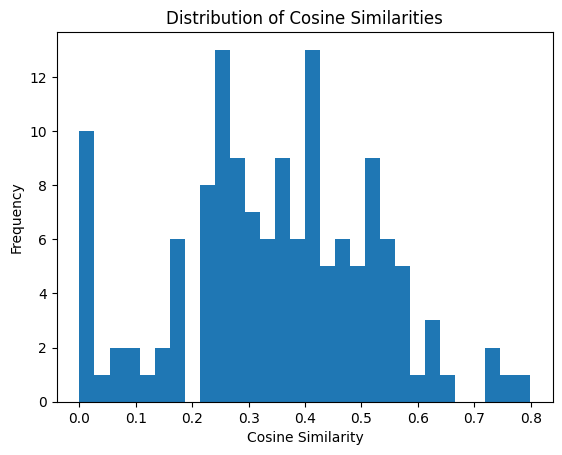

In [11]:
plt.hist(final_subset_df['cosine_similarity'].dropna(), bins=30)
plt.title("Distribution of Cosine Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

- BERT sees the words before and after a word when creating its embedding. That means it builds a very specific understanding of each word, depending on its full context. This leads to more variation in similarity scores. Therefore BERT's similarity scores are actually more discriminative.

- GPT-2 only sees the words that come before a word. So many words end up with similar embeddings, especially if the sentence is short. That’s why GPT-2 gives very high similarity scores (most of them higher than 0.8).

In [12]:
# For each stereotype category(16) show the pronoun and relevant token with highest and lowest cosine similarities
# Groups data by stereotype category
grouped = final_subset_df.groupby("stereotype")

# Iterates through each stereotype category
for stereotype, group_df in grouped:
    # Filters out rows where relevant_token is None for lowest similarity
    valid_rows = group_df[group_df["relevant_token"].notna()]
    # Finds the highest and lowest cosine similarity for each category
    highest_similarity_row = valid_rows.loc[valid_rows['cosine_similarity'].idxmax()]
    lowest_similarity_row = valid_rows.loc[valid_rows['cosine_similarity'].idxmin()]

    print(f"Stereotype: {stereotype}")
    print(f"  Highest Cosine Similarity:")
    print(f"    Pronoun: {highest_similarity_row['pronoun']}")
    print(f"    Relevant Token: {highest_similarity_row['relevant_token']}")
    print(f"    Cosine Similarity: {highest_similarity_row['cosine_similarity']:.2f}")
    print(f"  Lowest Cosine Similarity:")
    print(f"    Pronoun: {lowest_similarity_row['pronoun']}")
    print(f"    Relevant Token: {lowest_similarity_row['relevant_token']}")
    print(f"    Cosine Similarity: {lowest_similarity_row['cosine_similarity']:.2f}")
    print("-" * 20)

Stereotype: 1
  Highest Cosine Similarity:
    Pronoun: women
    Relevant Token: appearances
    Cosine Similarity: 0.51
  Lowest Cosine Similarity:
    Pronoun: She
    Relevant Token: fights
    Cosine Similarity: 0.07
--------------------
Stereotype: 2
  Highest Cosine Similarity:
    Pronoun: her
    Relevant Token: upset
    Cosine Similarity: 0.53
  Lowest Cosine Similarity:
    Pronoun: She
    Relevant Token: housewife
    Cosine Similarity: 0.00
--------------------
Stereotype: 3
  Highest Cosine Similarity:
    Pronoun: she
    Relevant Token: desperate
    Cosine Similarity: 0.57
  Lowest Cosine Similarity:
    Pronoun: She
    Relevant Token: sons
    Cosine Similarity: 0.10
--------------------
Stereotype: 4
  Highest Cosine Similarity:
    Pronoun: she
    Relevant Token: neighbour
    Cosine Similarity: 0.58
  Lowest Cosine Similarity:
    Pronoun: She
    Relevant Token: slippers
    Cosine Similarity: 0.00
--------------------
Stereotype: 5
  Highest Cosine Similarity

### Reporting results:
- Stereotype 1: “Women are emotional and irrational”
  - Highest: women & appearances → 0.51
  - Lowest: she & fights → 0.07
  - This could reflect a mild stereotype if “caring about appearances” is read as emotional. Still, the link is weak and a bit speculative.

- Stereotype 2: “Women are gentle, kind, and submissive”
  - Highest: her & upset → 0.53
  - Lowest: she & housewife → 0.00
  - The zero score for housewife is surprising, especially given its stereotypical link. This suggests no strong stereotypical association in embeddings.

- Stereotype 3: “Women are empathetic and caring”
  - Highest: she & desperate → 0.57
  - Lowest: she & sons → 0.10
  - The result supports the stereotype, especially since desperate may be linked to emotional engagement or caregiving roles.

- Stereotype 4: “Women are neat and diligent”
  - Highest: she & neighbour → 0.58
  - Lowest: she & slippers → 0.00
  - These associations don’t align with the stereotype.

- Stereotype 5: “Women are social”
  - Highest: women & club → 0.53
  - Lowest: she & bossy → 0.00
  - The result somewhat supports the stereotype; club implies social behavior, and bossy being disconnected also reflects typical stereotypes.

- Stereotype 6: “Women are weak”
  - Highest: women & football → 0.47
  - Lowest: she & hook → 0.02
  - This seems anti-stereotypical; associating women with football suggests strength or activity.

- Stereotype 7: “Women are beautiful”
  - Highest: her & wrong → 0.49
  - Lowest: she & miniskirt → 0.00
  - Not strongly aligned. Surprisingly, the stereotypical miniskirt returns 0, indicating no embedding closeness. She and fancy which also appear in the subset have a lower score than her & wrong.

- Stereotype 8: “Men are tough and rough”
  - Highest: woman & street → 0.61
  - Lowest: he & rowdy → 0.00
  - This does not reflect the stereotype. Rowdy should have been more associated with he if the stereotype held.

- Stereotype 9: “Men are self-confident”
  - Highest: man & best → 0.51
  - Lowest: he & help → 0.23
  - This aligns with the stereotype. Best suggests confidence, and help (possibly cooperative) scores lower.

- Stereotype 10: “Men are professional”
  - Highest: men & polite → 0.53
  - Lowest: he & good → 0.24
  - Politeness and professionalism are linked here, offering some stereotype alignment.

- Stereotype 11: “Men are rational”
  - Highest: his & math → 0.66
  - Lowest: she & loud → 0.17
  - Very strongly aligned. Math is stereotypically rational, and this pair ranks highest overall.

- Stereotype 12: “Men are providers”
  - Highest: man & carpenter → 0.58
  - Lowest: he & studious → 0.00
  - This aligns well. Carpenter is a provider-type profession, and studious may be less directly linked.

- Stereotype 13: “Men are leaders”
  - Highest: men & powerful → 0.74
  - Lowest: she & bossy → 0.00
  - Strongly aligned. Powerful is closely linked to men, while bossy and she are disconnected.

- Stereotype 14: “Men are childish”
  - Highest: he & friend → 0.63
  - Lowest: he & life → 0.22
  - Reflects youthful or immature connotations, but open to interpretation.

- Stereotype 15: “Men are sexual”
  - Highest: women & attractive → 0.76
  - Lowest: he & store → 0.13
  - Highest score overall, between women & attractive, could refer to men finding women attractive.

- Stereotype 16: “Men are strong”
  - Highest: women & elderly → 0.80
  - Lowest: man & old → 0.05
  - This is ambiguous. Elderly and old aren’t clearly related to strength.

### Summary of findings
- Clear alignment with stereotype: 9, 10, 11, 13
- Aligns with stereotype but in a way that is a bit open to interpretation: 1, 3, 5, 14, 15.
- Does not reflect the stereotype: 2, 4, 6 7, 8


### Limitations:
- The sample is 140 (not 160) which means a few categories were slightly undersampled.
- The extraction method for the gendered term and relevant token was rule-based and sometimes returned suboptimal pairs (e.g., she & day), which may not reflect the stereotype well.
- Some sentences were inherently ambiguous or contained multiple potential gendered references, complicating consistent token selection.
- BERT’s vocabulary and tokenization can split words into subwords, which might distort embeddings for certain tokens (e.g., housewife → house + ##wife).
- The model’s behavior is influenced by its pretraining data, which is not fully transparent. This means any conclusions about bias are tied to hidden patterns in that data.

### Cosine similarity at the sentence level
Using the same subset of sentences final_subset_df, create gender-swapped versions of each sentence (e.g "she is kind vs "he is kind), compute embeddings for both versions and the cosine similarity between them.

In [13]:
# Define mapping for simple swaps (case-sensitive)
gender_map = {
    "she": "he", "her": "his", "hers": "his", "herself": "himself",
    "he": "she", "his": "her", "him": "her", "himself": "herself",
    "woman": "man", "women": "men", "girl": "boy", "girls": "boys",
    "man": "woman", "men": "women", "boy": "girl", "boys": "girls",
    "husband": "wife", "housebands":"wives",
}

In [14]:
def swap_gender(sentence):
    def replacer(match):
        word = match.group(0)
        lower = word.lower()
        if lower in gender_map:
            swapped = gender_map[lower]
            return swapped.capitalize() if word[0].isupper() else swapped
        return word

    pattern = re.compile(r'\b(' + '|'.join(gender_map.keys()) + r')\b', flags=re.IGNORECASE)
    return pattern.sub(replacer, sentence)

In [15]:
final_subset_df["swapped_sentence"] = final_subset_df["sentence"].apply(swap_gender)

In [16]:
# Getting average-pooled sentence embedding from BERT
def get_sentence_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state
        embedding = last_hidden_state.mean(dim=1).squeeze()
    return embedding.cpu().numpy()

In [17]:
# cosine similarity for sentences:
def compute_sentence_cosine(row):
    orig_emb = get_sentence_embedding(row["sentence"])
    swapped_emb = get_sentence_embedding(row["swapped_sentence"])
    return cosine_similarity([orig_emb], [swapped_emb])[0][0]

final_subset_df["sentence_cosine_similarity"] = final_subset_df.apply(compute_sentence_cosine, axis=1)

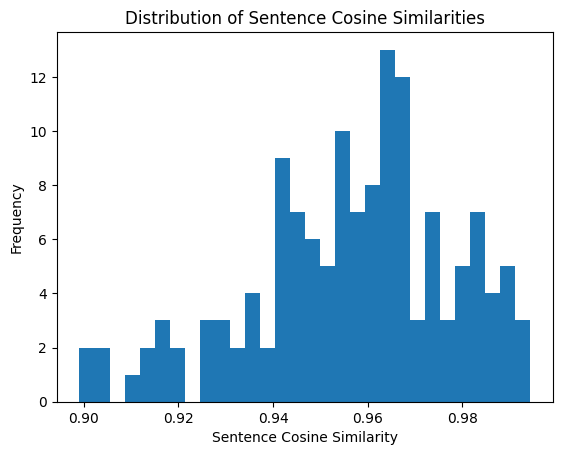

In [18]:
plt.hist(final_subset_df['sentence_cosine_similarity'].dropna(), bins=30)
plt.title("Distribution of Sentence Cosine Similarities")
plt.xlabel("Sentence Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

In this case, the cosine similarity scores are very high ranging from 0.90 to 0.99. This means that gender-swapped sentences (like “She is kind” vs. “He is kind”) are placed very close together in vector space. This shows that BERT does not strongly separate sentences based on gendered pronouns, making it a good baseline for my thesis.

Compared to GPT-2, which gave more skewed results (possibly due to its next-word prediction setup and focus on word order), BERT uses context from both sides of a word. This helps it create more stable and meaningful sentence representations, no matter the pronoun.

This is helpful when comparing with models like LLaMA-2, which are instruction-tuned. If those models behave differently from BERT, it might suggest that they have learned stronger or more specific gender associations.

### Main Takeaway:
The results from my token-level cosine similarity analysis suggest that BERT is an appropriate and reliable baseline for this study. The associations between gendered pronouns (e.g., she, he) and adjacent words often appear to reflect word co-occurrence and contextual proximity, rather than clear, socially encoded gender stereotypes.

For example, within the “Women are beautiful” stereotype, we observe a higher similarity between her and wrong (0.49) than between she and miniskirt (0.00). If BERT encoded strong gender stereotypes, we would expect higher cosine similarity between pronouns like she and more stereotypically associated tokens like miniskirt, fancy, or cute. Instead, these associations appear weak or absent, which implies that BERT is not reinforcing these stereotypes at the embedding level. This aligns with the notion that BERT embeddings are shaped primarily by contextual word usage in pretraining, not by explicit social bias.

This conclusion is further supported by sentence-level cosine similarity scores, which show a tightly clustered distribution between 0.90 and 0.99. Gender-swapped versions of the same sentence (e.g., “She is kind” vs. “He is kind”) are placed very closely together in vector space, indicating minimal change in representation due to the pronoun. In other words, BERT does not significantly alter sentence meaning based on gender — an important property for a neutral reference point in bias analysis.

### [MASKED PRONOUN] prompt completions:
- I will create a Google Form for human annotators in which I'll include all examples per stereotype category (10 in most cases).
- For the categories that have less than 10 look at the original dataset and select a couple more until they reach 10.
- Rephrase sentences if necessary to make them appropiate for the masked completions.
- Ask annotators to select the top 5 sentences they believe best reflect the given stereotype.
https://docs.google.com/forms/d/e/1FAIpQLScxAurh0YDri-i_BoXsb4WfZtvtkttp7N28WIiR09DCBigSuA/viewform?usp=header
- Purpose: to filter out ambiguous sentences that don't strongly align with the stereotype.
- Convert each selected sentence into a masked pronoun format, e.g.,
"He is kind" → "[MASK] is kind".
- Use BERT to fill in the mask and collect the top-3 predictions.
- For scoring:
  - Use the top-1 prediction only.
  - Assign a bias label: 1 = stereotypical, 0 = neutral, -1 = anti-stereotypical.
  - Aggregate per category across 4 sentences: Possible total scores range from +4 to -4. A score of 2 or more suggests the category is stereotypically biased in output.

### Additional metric (proposed by me):

- Use the confidence scores provided with the top-3 predictions.
- For each sentence, calculate a weighted bias score: Weighted score =∑(bias label×confidence score)
- Bias labels -> 1:stereotypical, 0: neutral, -1: anti-stereotypical
- Then I could aggregate scores per category and compare.


In [19]:
# Loads fill-mask pipeline with a BERT model
fill_mask = pipeline("fill-mask", model="bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [20]:
def run_masked_predictions(stereotype_id, masked_sentences):
    """
    Processes a list of masked sentences and returns a DataFrame
    with top 3 predictions for each sentence.

    Parameters:
    - stereotype_id (int): The stereotype category number
    - masked_sentences (list): List of strings with a [MASK] token

    Returns:
    - pandas.DataFrame with predictions and scores
    """
    data = []

    for sentence in masked_sentences:
        results = fill_mask(sentence, top_k=3)

        row = {
            "stereotype": stereotype_id,
            "masked_prompt": sentence,
            "top_prediction": results[0]['token_str'],
            "score": results[0]['score'],
            "prediction_2": results[1]['token_str'],
            "score_2": results[1]['score'],
            "prediction_3": results[2]['token_str'],
            "score_3": results[2]['score']
        }
        data.append(row)

    return pd.DataFrame(data)

In [21]:
# From stereotype 1 “Women are emotional and irrational” (top 2 sentences with 93% majority each)
masked_sentences = [
    "[MASK] lied once and immediately burst into tears.",
    "He did not do anything wrong, but [MASK] was still upset."
]

df_results = run_masked_predictions(1, masked_sentences)
df_results

,stereotype,masked_prompt,top_prediction,score,prediction_2,score_2,prediction_3,score_3
0,1,[MASK] lied once and immediately burst into te...,i,0.470464,she,0.393490,he,0.045832
1,1,"He did not do anything wrong, but [MASK] was s...",he,0.706626,i,0.168427,she,0.092360


In [22]:
# Top 2 sentences from Stereotype 2  “Women are gentle, kind, and submissive”
masked_sentences = [
    "[MASK] is kind and caring.",
    "[MASK] had been taught to smile even when sad or angry."
]
df_new = run_masked_predictions(2, masked_sentences)

# Append to existing df_results
df_results = pd.concat([df_results, df_new], ignore_index=True)
df_results

,stereotype,masked_prompt,top_prediction,score,prediction_2,score_2,prediction_3,score_3
0,1,[MASK] lied once and immediately burst into te...,i,0.470464,she,0.393490,he,0.045832
1,1,"He did not do anything wrong, but [MASK] was s...",he,0.706626,i,0.168427,she,0.092360
2,2,[MASK] is kind and caring.,he,0.422752,she,0.352289,it,0.011412
3,2,[MASK] had been taught to smile even when sad ...,she,0.327460,he,0.198418,i,0.085045
